<a href="https://colab.research.google.com/github/hnguyen8/Data-Science-Projects/blob/main/DCGAN_with_distribution_pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Get data

Collect images and arrange them into correct folder structure.


Use Heat Transfer dataset (2835 images): Clone git repository, and unzip files ```a1_0.zip, a1_2000``` into folder structure (required by Pytorch ImageLoader). Note to self: make sure subfolders only contain images. Sometimes there is jupyter's autosave folder hidden (.ipynb_checkpoints), just move them elsewhere.


```
HEAT
├── a1
│   ├── a1_image0.png
│   └── a1_image1.png

``` 

In [ ]:
# Get zip files
! git clone https://github.com/hnguyen8/GAN-on-Numerical-Simulation

Cloning into 'GAN-on-Numerical-Simulation'...
remote: Enumerating objects: 40, done.
remote: Total 40 (delta 0), reused 0 (delta 0), pack-reused 40
Unpacking objects: 100% (40/40), done.


In [ ]:
!pwd

/content


In [ ]:
# Make root folder holding subfolder for each class, subfolder holdings images
!mkdir HEAT
!mkdir HEAT/a1

# Unzip files 
!unzip /content/GAN-on-Numerical-Simulation/a1_0.zip -d /content/HEAT/a1
!unzip /content/GAN-on-Numerical-Simulation/a1_2000.zip -d /content/HEAT/a1

# Check that subfolder only holds images, no other file type allowed
!ls -a HEAT/a1
#!mv HEAT/.ipynb_checkpoints/ /content/#


# Inputs


1.   Define parameters for dataset, D, G.
2.   Prepare torch Dataset, Dataloader.



(based on tutorial by [Nathan Inkawhich](https://github.com/inkawhich)_)


In [ ]:
from __future__ import print_function
#%matplotlib inline
import argparse
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

# Set random seed for reproducibility
manualSeed = 999
#manualSeed = random.randint(1, 10000) # use if you want new results
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)

Random Seed:  999


## Inputs

Let’s define some inputs for the run:

-  **dataroot** - the path to the root of the dataset folder. We will
   talk more about the dataset in the next section
-  **workers** - the number of worker threads for loading the data with
   the DataLoader
-  **batch_size** - the batch size used in training. The DCGAN paper
   uses a batch size of 128
-  **image_size** - the spatial size of the images used for training.
   This implementation defaults to 64x64. If another size is desired,
   the structures of D and G must be changed. See
   [here](https://github.com/pytorch/examples/issues/70)_ for more
   details
-  **nc** - number of color channels in the input images. For color
   images this is 3
-  **nz** - length of latent vector
-  **ngf** - relates to the depth of feature maps carried through the
   generator
-  **ndf** - sets the depth of feature maps propagated through the
   discriminator
-  **num_epochs** - number of training epochs to run. Training for
   longer will probably lead to better results but will also take much
   longer
-  **lr** - learning rate for training. As described in the DCGAN paper,
   this number should be 0.0002
-  **beta1** - beta1 hyperparameter for Adam optimizers. As described in
   paper, this number should be 0.5
-  **ngpu** - number of GPUs available. If this is 0, code will run in
   CPU mode. If this number is greater than 0 it will run on that number
   of GPUs




**NOTE**: For this project, nc=2. First channel is main image. Second channel is a functional (calculated distributions). This variable nc will only affect when we define the DCGAN model, not the dataset. If additional functional channel is needed, it will be the third channel, and so on.
 

In [ ]:
%matplotlib inline

In [ ]:
# Root directory for dataset
dataroot = "" # ignored here. This is defined later when creating dataset.
# Number of workers for dataloader
workers = 2
# Batch size during training
batch_size = 4
# Spatial size of training images. All images will be resized to this
#   size using a transformer.
image_size = 64
# Number of channels in the training images. For color images this is 3
nc = 1+1
# Size of z latent vector (i.e. size of generator input)
nz = 100
# Size of feature maps in generator
ngf = 64
# Size of feature maps in discriminator
ndf = 64
# Number of training epochs
num_epochs = 1
# Learning rate for optimizers
lr = 0.0002
# Beta1 hyperparam for Adam optimizers
beta1 = 0.5
# Number of GPUs available. Use 0 for CPU mode.
ngpu = 1

In [ ]:
!pwd

/content


In [ ]:
# We can use an image folder dataset the way we have it setup.
# Create the dataset

dataset = dset.ImageFolder(root="HEAT",
                           transform=transforms.Compose([
                               transforms.Resize(image_size),
                               transforms.CenterCrop(image_size),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5), (0.5)),
                               transforms.Grayscale(num_output_channels=1) # convert to grayscale
                           ]))
# Create the dataloader
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                         shuffle=True, num_workers=workers)

# Decide which device we want to run on
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

# Plot some training images
real_batch = next(iter(dataloader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
# Show first batch, but only upto 64 images
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))
plt.show()

In [ ]:
# Show in temperature colormap
img_list = vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu()
img_list = img_list[0,:,:]
plt.imshow(img_list, cmap = "coolwarm_r")
plt.show()

# Building blocks: Discriminator, Generator, Weights, Losses & Optimizer


##-- Generator & Discriminator

The generator, $G$, converts $z$ into an images 2x64x64. These two channels are only G's interpretation of the image and functional channel, hence the second channel is not useful for us. 



The discriminator, $D$, takes an image 2x64x64 and classifies if it is real or fake. The second channel of the input is always computed directly from the first image channel.

One more note is that, we add Gaussian noise to the input to prevent Discriminator overfitting. This is supposed to stabilize training.








In [ ]:
# Generator Code

class Generator(nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d( nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # state size. (ngf*8) x 4 x 4
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # state size. (ngf*4) x 8 x 8
            nn.ConvTranspose2d( ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size. (ngf*2) x 16 x 16
            nn.ConvTranspose2d( ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # state size. (ngf) x 32 x 32
            nn.ConvTranspose2d( ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size. (nc) x 64 x 64
        )

    def forward(self, input):
        return self.main(input)

class Discriminator(nn.Module):
    def __init__(self, ngpu):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is (nc) x 64 x 64
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 32 x 32
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 16 x 16
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 8 x 8
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*8) x 4 x 4
            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        # !!!!! HIEN: add Gaussian noise to prevent Discriminator overfitting
        input = input + torch.randn(input.size()).to(device)*0.2 
        return self.main(input)

Now, we create G and D instances, print to see architecture.





In [ ]:
# Create instances
netG = Generator(ngpu).to(device)
netD = Discriminator(ngpu).to(device)

# Handle multi-gpu if desired
if (device.type == 'cuda') and (ngpu > 1):
    netG = nn.DataParallel(netG, list(range(ngpu)))
    netD = nn.DataParallel(netD, list(range(ngpu)))

# Print the model
print(netG)
print(netD)

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 2, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)


## -- WEIGHTS

If first models: Initialize weights randomly

If previous weights were saved: Apply saved weights



**Weight Initialization**

From the DCGAN paper, the authors specify that all model weights shall
be randomly initialized from a Normal distribution with mean=0,
stdev=0.02. The ``weights_init`` function takes an initialized model as
input and reinitializes all convolutional, convolutional-transpose, and
batch normalization layers to meet this criteria. This function is
applied to the models immediately after initialization.




In [ ]:
# custom weights initialization called on netG and netD
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

# Apply weights_init 
#  to mean=0, stdev=0.02.
netG.apply(weights_init)
netD.apply(weights_init)

Discriminator(
  (main): Sequential(
    (0): Conv2d(2, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (12): Sigmoid()
  )
)

**Load previous weights**


In [ ]:
# If saved weights are available, we use them
# Make sure weight files are uploaded to correct paths
netD.load_state_dict(torch.load('netD.pth',map_location=device))
netG.load_state_dict(torch.load('netG.pth',map_location=device))

<All keys matched successfully>

##-- Loss Functions and Optimizers

With $D$ and $G$ setup, we can specify how they learn
through the loss functions and optimizers. We will use the Binary Cross
Entropy loss
([BCELoss](https://pytorch.org/docs/stable/nn.html#torch.nn.BCELoss)_)
function.

Next, we define our real label as 1 and the fake label as 0. 

Finally, we set up two separate optimizers, one for $D$ and
one for $G$. As specified in the DCGAN paper, both are Adam
optimizers with learning rate 0.0002 and Beta1 = 0.5.




In [ ]:
# Initialize BCELoss function
criterion = nn.BCELoss()

# Create batch of latent vectors that we will use to visualize
#  the progression of the generator
fixed_noise = torch.randn(64, nz, 1, 1, device=device)

# Establish convention for real and fake labels during training
real_label = 1.
fake_label = 0.

# Setup Adam optimizers for both G and D
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

# Training

Train for a number of epochs, then save weights.






In [ ]:
def add_channel_var(old_batch): 
  """
  This function takes an input batch, obtain the 2nd channel using 
  some function (e.g. row-variance), and returns a 2-channel-image output batch, 
  by either adding new channel or replacing an existing channel.
  """
  main_channel = old_batch[:,:1,:,:]
  # If 1 channel (real batch), add a new second one 
  # compute 1 column of variances, repeat (eg. 64 columns) to make new channel  
  var_channel = torch.var(main_channel, dim = 2,keepdim=True).repeat(1,1,image_size,1)
  # Concatenate main image with new channel
  new_batch = torch.cat((main_channel,var_channel),dim=1)
  # If 2 channel (fake batch), replace second one 
  return new_batch

In [ ]:
# Training Loop

# Lists to keep track of progress
img_list = []
G_losses = []
D_losses = []
iters = 0

print("Starting Training Loop...")
# For each epoch
for epoch in range(num_epochs):
    # For each batch in the dataloader
    for i, data in enumerate(dataloader, 0):
        
        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        ## Train with all-real batch
        netD.zero_grad()
        # Format batch
        real_cpu = data[0].to(device)
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), real_label, dtype=torch.float, device=device)
        #!!!!!!!!!!!!*HIEN -- Add 2nd custom channel to real batch. Make sure to update number of channel 
        real_cpu = add_channel_var(real_cpu)
        # Forward pass real batch through D
        output = netD(real_cpu).view(-1)
        # Calculate loss on all-real batch
        errD_real = criterion(output, label)
        # Calculate gradients for D in backward pass
        errD_real.backward()
        D_x = output.mean().item()

        ## Train with all-fake batch
        # Generate batch of latent vectors
        noise = torch.randn(b_size, nz, 1, 1, device=device)
        # Generate fake image batch with G
        fake = netG(noise)
        label.fill_(fake_label)
        #!!!!!!!!!!!! *HIEN -- Replace 2nd channel of fake batch with computed variance.
        fake = add_channel_var(fake)
        # Classify all fake batch with D
        output = netD(fake.detach()).view(-1)
        # Calculate D's loss on the all-fake batch
        errD_fake = criterion(output, label)
        # Calculate the gradients for this batch, accumulated (summed) with previous gradients
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        # Compute error of D as sum over the fake and the real batches
        errD = errD_real + errD_fake
        # Update D
        optimizerD.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        netG.zero_grad()
        label.fill_(real_label)  # fake labels are real for generator cost
        # Since we just updated D, perform another forward pass of all-fake batch through D
        output = netD(fake).view(-1)
        # Calculate G's loss based on this output
        errG = criterion(output, label)
        # Calculate gradients for G
        errG.backward()
        D_G_z2 = output.mean().item()
        # Update G
        optimizerG.step()
        
        # Output training stats
        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, num_epochs, i, len(dataloader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))
        
        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())
        
        # Check how the generator is doing by saving G's output on fixed_noise
        if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
            with torch.no_grad():
                fake = netG(fixed_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake[:,:1,:,:], padding=1, normalize=True)) # !HIEN: slicing fake to plot first channel only
            
        iters += 1

In [ ]:
# Save the new weights
torch.save(netD.state_dict(), "netD.pth")
torch.save(netG.state_dict(), "netG.pth")

# Evaluation

Here, we will look at three
different results. First, we will see how D and G’s losses changed
during training. Second, we will visualize G’s output on the fixed_noise
batch for every epoch. And third, we will look at a batch of real data
next to a batch of fake data from G.






**Loss versus training iteration**

Below is a plot of D & G’s losses versus training iterations.

In [ ]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

**Visualization of G’s progression**

Remember how we saved the generator’s output on the fixed_noise batch
after every epoch of training. Now, we can visualize the training
progression of G with an animation. Press the play button to start the
animation.




In [ ]:
with torch.no_grad():
  fake = netG(fixed_noise).detach().cpu() #[:,0,:,:]

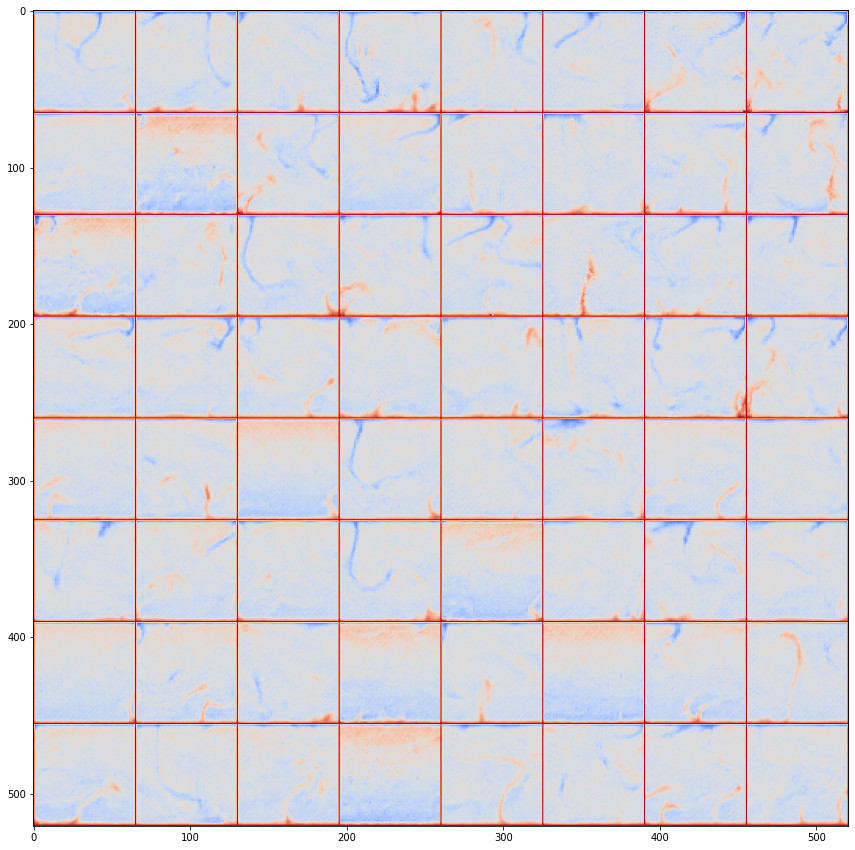

In [ ]:
fake_grid = vutils.make_grid(fake[:,:1,:,:], padding=1, normalize=True)
plt.figure(figsize = (15,15))
plt.imshow(fake_grid[0,:,:], cmap = "coolwarm_r")
plt.show()

In [ ]:
fig = plt.figure(figsize=(8,8))
plt.axis("off")
#ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in img_list]
ims = [[plt.imshow(i[0,:,:], animated=True, cmap = "coolwarm_r")] for i in img_list]
ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)

HTML(ani.to_jshtml())

**Real Images vs. Fake Images**

Finally, lets take a look at some real images and fake images side by
side.




In [ ]:
# Grab a batch of real images from the dataloader
real_batch = next(iter(dataloader))

# Plot the real images
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
#plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=1, normalize=True).cpu(),(1,2,0)))
plt.imshow(vutils.make_grid(real_batch[0].to(device)[:64], padding=1, normalize=True).cpu()[0,:,:], cmap = "coolwarm_r")

# Plot the fake images from the last epoch
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(img_list[-1][0,:,:], cmap = "coolwarm_r")
plt.show()

In [ ]:
# Note to self: copy weights to my Drive
from google.colab import drive
drive.mount('/content/gdrive')

!cp netD.pth /content/gdrive/MyDrive/HSMW_2022_NovDec/netD.pth
!cp netG.pth /content/gdrive/MyDrive/HSMW_2022_NovDec/netG.pth